In [1]:
from __future__ import division
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import gmres, minres, cg
import scipy.sparse.linalg as spla
import time
import math
np.set_printoptions(suppress=True)
plt.rc('font',family='serif')
%matplotlib inline

In [69]:
# Obtain xl,xr positions for each element
def get_xlxr(mesh):
    xlxr=np.zeros((len(mesh)-1,2))
    xlxr[:,0]=mesh[:-1]
    xlxr[:,1]=mesh[1:]
    return xlxr

### 1. PBE Model

$\frac{\partial F}{\partial t} + \frac{\partial}{\partial V}(F \frac{dV}{dt}) = 0$

$F(V,0|\mu,{\sigma}^2) = \frac{1}{\sqrt{2\pi {\sigma}^2}}e^{-\frac{(V-\mu)^2}{2\sigma ^2}}$

$\frac{dV}{dt} = c$

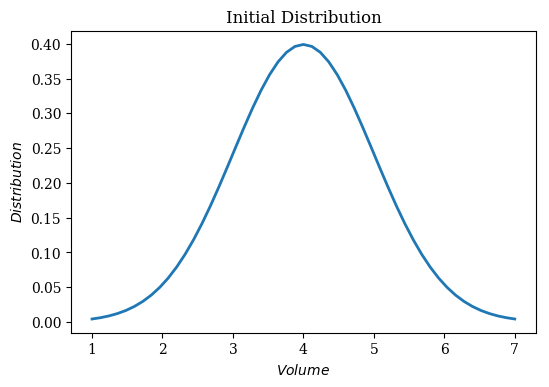

In [141]:
dvdt=0.05

a=1
b=7

# Number of elements
n=50
# Defining the mesh, ie, node positions
v=np.linspace(a,b,n+1)
# Get pairs of points for each element 
xlxr=get_xlxr(v)
# Time step
dt=1/100

sigma2=1
mu=4

F_init=(1/np.sqrt(2*math.pi*sigma2))*np.exp(-(v-mu)**2/(2*sigma2))

plt.figure(num=None,figsize=(6,4),dpi=100,facecolor='w',edgecolor='k')
plt.plot(v,F_init,lw=2)
plt.ylabel('$Distribution$')
plt.xlabel('$Volume$')
plt.title('Initial Distribution');

### 3. Weak Formulation

$\int_{\Omega ^e} w \frac{\partial F}{\partial t} dV + \int_{\Omega ^e} (c = \frac{\partial V}{\partial t})w \frac{\partial}{\partial V}F dV  = 0$

$F = \sum_{j = 1}^{n} F_j(t)\Psi _j(V)$

$w = \Psi _i(V)$

$\sum_{j = 1}^{n} \int_{\Omega ^e}\Psi _i \Psi _j dV \frac{\partial F_j}{\partial t} + \sum_{j = 1}^{n} \int_{\Omega ^e} c\Psi _i \frac{\partial \Psi _j}{\partial V}dV F_j = 0$

### 4. Gaussian Quadrature 

Reference element [0,1] 

$\int_a^b f(x)dx = \int_0^1(b-a)f(a+(b-a)\xi)d\xi$

In [142]:
def reftoreal(x,a,b):
    return a+(b-a)*x


def GQintegrate(integrand):
    nodes=[0.5-1/(2*np.sqrt(3)),0.5+1/(2*np.sqrt(3))]
    weights=[0.5,0.5]
    result=0
    result+=weights[0]*integrand(nodes[0])
    result+=weights[1]*integrand(nodes[1])
    return result

### 5. Shape functions over reference element

$$\Psi_0(x)=1-x$$

$\Psi_1(x)=x$

$\frac{d}{dx}\Psi_0(x)=-1$

$\frac{d}{dx}\Psi_1(x)=1$

### 6. Mass matrix

Local element mass matrix 
$M_{i,j}^e = \int_{\Omega ^e} \Psi _i\Psi _jJ^e dx$

Global mass matrix
$M = \sum_{e = 1}^{n}A^{eT}M^eA^e$

In [143]:
# Local element mass matrix
def localmass(element):
    a=element[0]
    b=element[1]
    M_e=np.zeros((2,2))
    J_e=(b-a)/2.0
    for i in range(len(element)): # Consider each node
        for j in range(i+1): # Consider each shape function
            integrand=lambda x:(b-a)*phi(i)(a+(b-a)*x)*phi(j)(a+(b-a)*x)*J_e
            M_e[i,j]=GQintegrate(integrand)
            M_e[j,i]=M_e[i,j]
    return M_e

In [144]:
# Assembling global mass matrix 
M=np.zeros((n+1,n+1))
for i in range(n): # Going through each element
    A=np.eye(2,n+1,i,dtype=int)
    M_e=localmass(xlxr[i])
    M+=np.transpose(A)@M_e@A    

In [145]:
print(M)

[[ 0.00000864 -0.00022464  0.         ...  0.          0.
   0.        ]
 [-0.00022464  0.00770112 -0.00070848 ...  0.          0.
   0.        ]
 [ 0.         -0.00070848  0.00872064 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.16769664 -0.08192448
   0.        ]
 [ 0.          0.          0.         ... -0.08192448  0.17358912
  -0.08489664]
 [ 0.          0.          0.         ...  0.         -0.08489664
   0.11348064]]


### 7. Stiffness Matrix

In [146]:
# Local stiffness matrix for an element
def localstiffness(element,dvdt):
    b=element[1]
    a=element[0]
    J_e=(b-a)/2.0
    K_e=np.zeros((2,2))
    for i in range(len(element)): 
        for j in range(i+1):
            integrand=lambda x:(dvdt*(b-a)*phi(i)(a+(b-a)*x)*dphi(j)*1/J_e)*J_e
            K_e[i,j]=GQintegrate(integrand)
            K_e[j,i]=K_e[i,j]
    return K_e

In [147]:
# Assembling global stiffness matrix
K=np.zeros((n+1,n+1))
for i in range(n): # Going through each elementsigma=1
    A=np.eye(2,n+1,i,dtype=int)
    K_e=localstiffness(xlxr[i],dvdt)
    K+=np.transpose(A)@K_e@A

In [148]:
print(K)

[[ 0.00009 -0.00309  0.      ...  0.       0.       0.     ]
 [-0.00309  0.00336 -0.00327 ...  0.       0.       0.     ]
 [ 0.      -0.00327  0.00372 ...  0.       0.       0.     ]
 ...
 [ 0.       0.       0.      ...  0.02028 -0.01173  0.     ]
 [ 0.       0.       0.      ... -0.01173  0.02064 -0.01191]
 [ 0.       0.       0.      ...  0.      -0.01191  0.01191]]


In [149]:
# Applying Dirichlet boundary conditions
K[0,:]=np.zeros(n+1)
K[:,0]=np.zeros(n+1)
K[0,0]=1   

In [150]:
print(K)

[[ 1.       0.       0.      ...  0.       0.       0.     ]
 [ 0.       0.00336 -0.00327 ...  0.       0.       0.     ]
 [ 0.      -0.00327  0.00372 ...  0.       0.       0.     ]
 ...
 [ 0.       0.       0.      ...  0.02028 -0.01173  0.     ]
 [ 0.       0.       0.      ... -0.01173  0.02064 -0.01191]
 [ 0.       0.       0.      ...  0.      -0.01191  0.01191]]


In [151]:
print(F_init)

[0.00443185 0.00630673 0.00884645 0.01223153 0.0166701  0.02239453
 0.02965458 0.03870686 0.04980009 0.06315656 0.07895016 0.09728227
 0.1181573  0.14145997 0.16693704 0.19418605 0.2226535  0.25164434
 0.28034381 0.30785126 0.3332246  0.35553253 0.37391061 0.38761662
 0.39608021 0.39894228 0.39608021 0.38761662 0.37391061 0.35553253
 0.3332246  0.30785126 0.28034381 0.25164434 0.2226535  0.19418605
 0.16693704 0.14145997 0.1181573  0.09728227 0.07895016 0.06315656
 0.04980009 0.03870686 0.02965458 0.02239453 0.0166701  0.01223153
 0.00884645 0.00630673 0.00443185]


In [162]:
F=F_init
Fs=[F]
vs=[v]
t=0.5
steps=t/dt
step=1

while step<=steps:
    F=np.linalg.inv(M)@(M@F-dt*K@F)
    F[0]=1
    Fs.append(F)
    v=(dvdt*dt)+v
    vs.append(v)
    step+=1

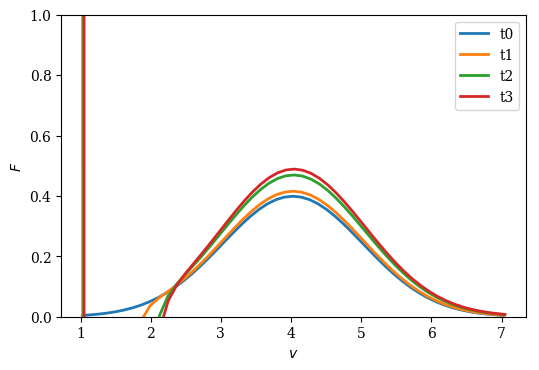

In [166]:
plt.figure(num=None,figsize=(6,4),dpi=100,facecolor='w',edgecolor='k')
plt.plot(vs[0],Fs[0],label='t0',lw=2)
plt.plot(vs[10],Fs[10],label='t1',lw=2)
plt.plot(vs[40],Fs[40],label='t2',lw=2)
plt.plot(vs[50],Fs[50],label='t3',lw=2)
plt.ylabel('$F$')
plt.xlabel('$v$')
plt.ylim(0,1)
plt.legend();

In [161]:
Fs[1]

array([-21.75062114,  -0.63313938,  -0.04404633,   0.00538088,
         0.01555591,   0.02225541,   0.02974457,   0.03888803,
         0.05004849,   0.06347359,   0.07934365,   0.0977616 ,
         0.11873173,   0.14213772,   0.16772465,   0.19508778,
         0.22367087,   0.25277577,   0.28158441,   0.30919278,
         0.33465557,   0.35703856,   0.3754749 ,   0.38922055,
         0.39770404,   0.40056589,   0.39768386,   0.38918166,
         0.37542011,   0.35697174,   0.33458135,   0.30911616,
         0.28151033,   0.25270876,   0.22361469,   0.19504525,
         0.16769748,   0.14212652,   0.11873608,   0.09778026,
         0.07937484,   0.06351562,   0.05010114,   0.03895723,
         0.02986117,   0.02256366,   0.01680746,   0.01234215,
         0.00893471,   0.00637633,   0.00448588])

In [155]:
vs[0]

array([1.  , 1.12, 1.24, 1.36, 1.48, 1.6 , 1.72, 1.84, 1.96, 2.08, 2.2 ,
       2.32, 2.44, 2.56, 2.68, 2.8 , 2.92, 3.04, 3.16, 3.28, 3.4 , 3.52,
       3.64, 3.76, 3.88, 4.  , 4.12, 4.24, 4.36, 4.48, 4.6 , 4.72, 4.84,
       4.96, 5.08, 5.2 , 5.32, 5.44, 5.56, 5.68, 5.8 , 5.92, 6.04, 6.16,
       6.28, 6.4 , 6.52, 6.64, 6.76, 6.88, 7.  ])

In [156]:
steps

50.0